In [1]:
%env HSA_OVERRIDE_GFX_VERSION="10.3.1 python"
import torch
from torch.autograd import Variable as V
from torchvision.io import read_image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.spatial.transform import Rotation as R

env: HSA_OVERRIDE_GFX_VERSION="10.3.1 python"


In [2]:
torch.autograd.set_detect_anomaly(False)  # use to detect nans (SLOW!!)

if torch.cuda.is_available():
    device = torch.device("cuda")  # works for ROCm too
    print('cuda devices:', torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f'\t{torch.cuda.get_device_properties(i).name}')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device = torch.device("cpu")
torch.set_default_device(device)
dtype = torch.float
torch.set_default_dtype(dtype)

In [15]:
class NeRF2d(torch.nn.Module):
    def __init__(self, res=100, samples_per_ray=100, focal_length=0.01, camera_size=0.01,
                 layer_size=64, enc=False, x_enc_dim=10, dir_enc_dim=6):
        super().__init__()
        self.layer_size = layer_size
        def enc_n(x, n):
            out = torch.zeros((x.shape[0], n * 4))
            xs = x[:, 0]
            ys = x[:, 1]
            for i in range(n):
                out[:, i * 4 + 0] = torch.cos(i * xs)
                out[:, i * 4 + 1] = torch.sin(i * xs)
                out[:, i * 4 + 2] = torch.cos(i * ys)
                out[:, i * 4 + 3] = torch.sin(i * ys)
            return out
    
        x_input_size = 2
        dir_input_size = 2
        self.enc_x_func = lambda x: x
        self.enc_dir_func = lambda dir: dir
        
        if enc:
            self.enc_x_func = lambda x: enc_n(x, x_enc_dim)
            self.enc_dir_func = lambda dir: enc_n(dir, dir_enc_dim)
            x_input_size = 4 * x_enc_dim
            dir_input_size = 4 * dir_enc_dim

        self.d1 = torch.nn.Sequential(
            torch.nn.Linear(x_input_size, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.LeakyReLU(),
        )
        self.d2 = torch.nn.Sequential(
            torch.nn.Linear(layer_size + x_input_size, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, 4)
        )
        self.res = res
        self.max_dist = 2
        self.focal_length = focal_length
        self.samples_per_ray = samples_per_ray
        self.camera_size = camera_size
        print(f'res: {res}\n'
              f'max_dist: {self.max_dist}\n'
              f'focal_length: {focal_length}\n'
              f'samples_per_ray: {samples_per_ray}\n'
              f'camera_size: {camera_size}\n'
              f'fov: {2 * np.arctan2(camera_size / 2, focal_length) * 180 / np.pi} degrees')

    def forward(self, x, dirs):
        x = self.enc_x_func(x)
        dirs = self.enc_dir_func(dirs)
        curr = self.d1(x)
        curr = torch.cat((curr, x), dim=1)
        curr = self.d2(curr)
        density = torch.nn.functional.relu(curr[:, 1].unsqueeze(1))
        # density = curr[:, 1].unsqueeze(1)
        colour = torch.sigmoid(curr[:, 1:])
        # colour = curr[:, 1:]
        return density, colour

    def render(self, angle):
        angle = torch.tensor(angle)
        h = self.max_dist / self.samples_per_ray
        camera_pos = torch.tensor([torch.sin(angle), torch.cos(angle)])
        camera_dir = -camera_pos
        camera_tangent = torch.tensor([-camera_dir[1], camera_dir[0]])
        # print(f'camera_pos: {camera_pos}\n'
              # f'camera_dir: {camera_dir}\n'
              # f'camera_tangent: {camera_tangent}')
        offsets = torch.linspace(-1, 1, self.res) * self.camera_size / 2
        origins = torch.zeros((self.res, 2))
        dirs = camera_dir.tile((self.res, 1)) * self.focal_length \
               + offsets.tile((2, 1)).transpose(0, 1) * camera_tangent.tile((self.res, 1))
        origins = camera_pos.tile((self.res, 1)) + dirs
        dirs = dirs / dirs.norm(dim=0)
        
        density_so_far = torch.zeros((self.res, 1), device=device, requires_grad=True)
        pixels = torch.zeros((self.res, 3), device=device, requires_grad=True)

        prev_t = 0
        for s in torch.arange(0, self.max_dist, h):
            t = s + torch.rand((1,)) * h
            # t = s
            x = origins + t * dirs

            # HERE -------------------------------
            density, colour = self(x, dirs)
            # HERE -------------------------------

            delta = (t - prev_t)

            # print(colour)

            density_so_far = density_so_far + delta * density
            T = torch.exp(-density_so_far)
            alpha = 1 - torch.exp(-delta * density)

            pixels = pixels + T * alpha * colour
            
            prev_t = t

        return pixels


    def train(self, training_angles, training_imgs, num_epochs=25, lr=0.001, block_size=None, print_n=10):
        N = len(training_angles)
        if block_size == None:
            block_size = N
        for k in range(num_epochs):
            # print(f'\nepoch {k+1:>3}/{num_epochs} ----------------')
            order = torch.randperm(N)
            i = 0
            for j in range(N // block_size):
                s = 0
                self.zero_grad()
                for p in range(j * block_size, min((j + 1) * block_size, N)):
                    sample = order[i]
                    theta = training_angles[sample]
                    gt_img = training_imgs[sample]
                    gen_img = self.render(theta)
                    loss = (gt_img - gen_img).norm() ** 2 / block_size
                    loss.backward()
                    s += loss.item()
                    i += 1
                n = 0
                for param in self.parameters():
                    param.data -= param.grad * lr
                    n += param.grad.norm().item()
            if (k+1) % print_n == 0:
                print(f'epoch {k+1}/{num_epochs} loss: {s:>.5}')
            # self.plot_example(torch.randint(low=0, high=N, size=(1,)).item())
            # plt.figure(figsize=(4,2))
            # plt.plot(self.render(0).detach().numpy())

res = 100
size = 10
n = NeRF2d(res=res, enc=True)

res: 100
max_dist: 2
focal_length: 0.01
samples_per_ray: 100
camera_size: 0.01
fov: 53.13010235415598 degrees


min: 0.11889021843671799 max: 0.209073007106781


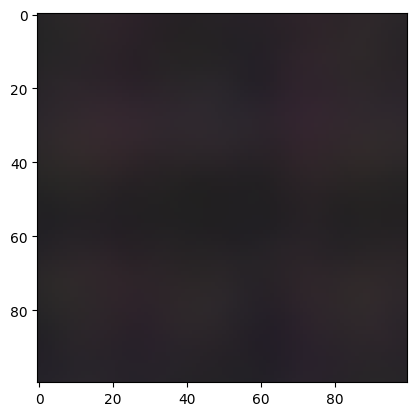

In [5]:
def imshow_nerf(nerf, theta, ax):
    theta = torch.tensor(theta)
    field_size = 100
    scene = torch.zeros(field_size, field_size, 3)
    pts_one_axis = torch.linspace(-1, 1, field_size)
    pts = torch.cartesian_prod(pts_one_axis, pts_one_axis)
    dirs = torch.tensor([[torch.cos(theta), torch.sin(theta)]]).tile((pts.shape[0], 1))
    densities, cols = nerf(pts, dirs)
    scene = (torch.sigmoid(densities - 1).tile((1, 1, 3)) * cols).reshape((field_size, field_size, 3))
    print(f'min: {scene.min()} max: {scene.max()}')
    # scene = (scene - scene.min()) / (scene.max() - scene.min())
    # scene[scene==torch.nan] = scene.mean()
    ax.imshow(scene.cpu().detach().numpy())
imshow_nerf(n, 0, plt)

In [6]:
class SceneObject:
    def __init__(self, centre, size, colour):
        self.centre = centre
        self.size = size
        self.colour = colour

class Square(SceneObject):
    def sdf(self, p):
        return torch.abs(p - self.centre).max() - self.size

class Circle(SceneObject):
    def sdf(self, p):
        return (p - self.centre).norm() - self.size

class Scene:
    def __init__(self):
        self.objects = []
    def min_sdf(self, p):
        return min([obj.sdf(p) for obj in self.objects])

    def closest_object(self, p):
        if len(self.objects) == 0:
            return None
        closest = None
        min_sdf = np.inf
        for obj in self.objects:
            if obj.sdf(p) < min_sdf:
                closest = obj
                min_sdf = obj.sdf(p)
        return closest

In [7]:
def march_ray(scene: Scene, origin, direction, max_dist):
    t = 0
    dir = direction / direction.norm()
    while t < max_dist:
        p = origin + t * dir
        dist = scene.min_sdf(p)
        if dist <= 0.00001:
            return scene.closest_object(p).colour
        t += dist
    return torch.zeros(3)

def raymarch_image(scene: Scene, res, focal_length, camera_size, max_dist, theta):
    camera_pos = torch.tensor([torch.sin(angle), torch.cos(angle)])
    camera_dir = -camera_pos
    camera_tangent = torch.tensor([-camera_dir[1], camera_dir[0]])
    offsets = torch.linspace(-1, 1, res) * camera_size / 2
    pixels = torch.zeros((res, 3))
    for i in range(res):
        origin = camera_pos + camera_dir * focal_length + offsets[i] * camera_tangent
        dir = camera_dir * focal_length + offsets[i] * camera_tangent
        dir /= dir.norm();
        pixels[i, :] = march_ray(scene, origin, dir, max_dist)
    return pixels

In [8]:
red = torch.tensor([1, 0, 0])
blue = torch.tensor([0, 0, 1])
scene = Scene()
scene.objects.append(Square(torch.tensor([0.2, 0.1]), 0.1, red))
scene.objects.append(Circle(torch.tensor([-0.3, -0.2]), 0.25, blue))
print(scene.objects)

N = 25
angles = torch.rand(N)
imgs = []
for angle in angles:
    print(len(imgs))
    imgs.append(raymarch_image(scene, n.res, n.focal_length, n.camera_size, n.max_dist, angle))

[<__main__.Square object at 0x15994e2d0>, <__main__.Circle object at 0x15996d750>]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


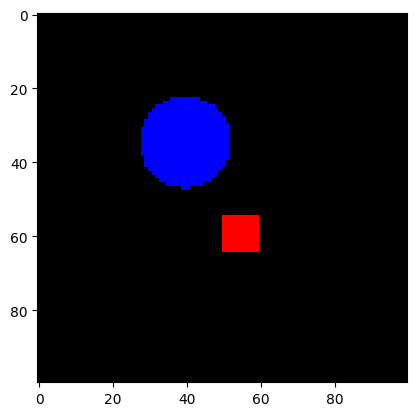

In [9]:
def imshow_scene(ax):
    field_size = 100
    pts_one_axis = torch.linspace(-1, 1, field_size)
    sdf_field = torch.zeros((field_size, field_size, 3))
    for i in range(len(pts_one_axis)):
        for j in range(len(pts_one_axis)):
            p = torch.tensor([pts_one_axis[i], pts_one_axis[j]])
            # print(p, scene.closest_object(p), scene.min_sdf(p))
            if scene.min_sdf(p) < 0:
                sdf_field[i, j, :] = scene.closest_object(p).colour
    ax.imshow(sdf_field.cpu().detach().numpy())
imshow_scene(plt)

/opt/homebrew/lib/python3.11/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


min: 0.11889021843671799 max: 0.209073007106781


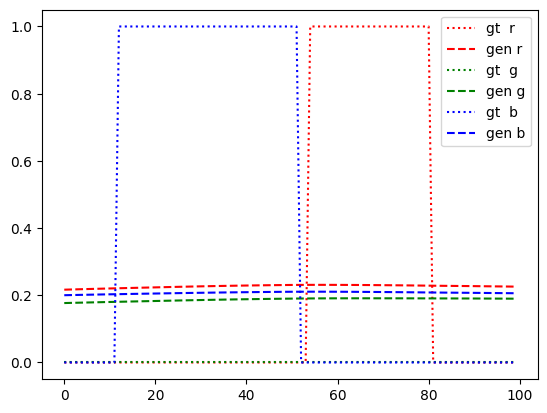

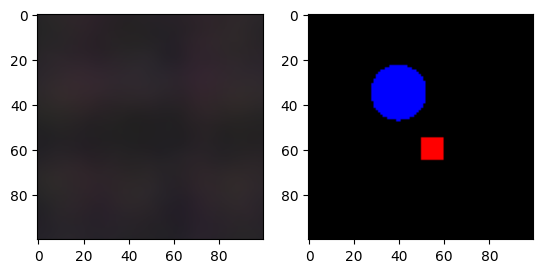

In [10]:
def compare(i=torch.randint(N, (1,))):
    gt_i = imgs[i].cpu().detach().numpy()
    render_i = n.render(i).cpu().detach().numpy()

    cols = ['r', 'g', 'b']
    for j in range(3):
        plt.plot(gt_i[:, j], color=cols[j], linestyle=':', label=f'gt  {cols[j]}')
        plt.plot(render_i[:, j], color=cols[j], linestyle='--', label=f'gen {cols[j]}')
        plt.legend()
    
    fig, [ax1, ax2] = plt.subplots(1, 2)
    imshow_nerf(n, angles[i], ax1)
    imshow_scene(ax2)
compare()

epoch 10/100 loss: 48.609
epoch 20/100 loss: 43.265
epoch 30/100 loss: 41.779
epoch 40/100 loss: 41.441
epoch 50/100 loss: 41.422
epoch 60/100 loss: 41.322
epoch 70/100 loss: 41.151
epoch 80/100 loss: 40.971
epoch 90/100 loss: 40.876
epoch 100/100 loss: 40.785
min: 0.016370169818401337 max: 0.33274438977241516


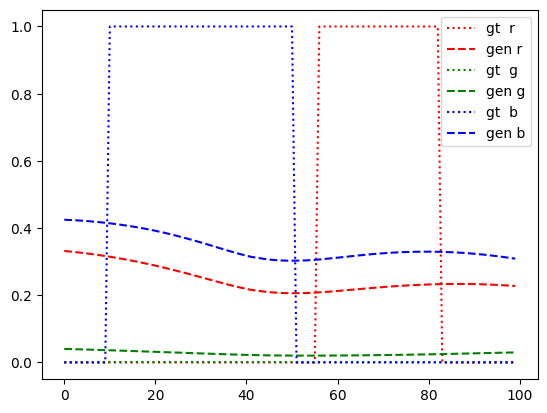

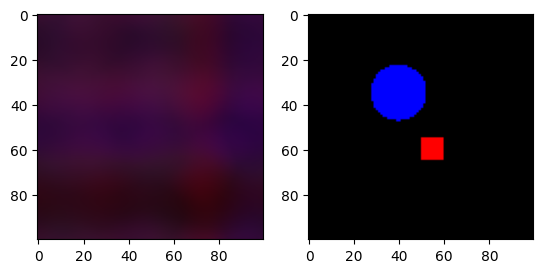

In [21]:
n.train(angles, imgs, lr=0.005, num_epochs=100, print_n=10)
compare(0)

min: 0.016370169818401337 max: 0.33274438977241516


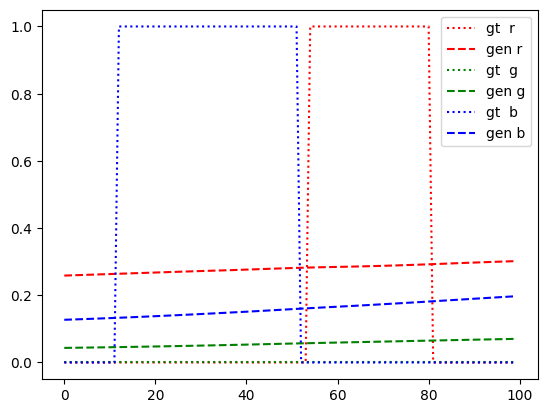

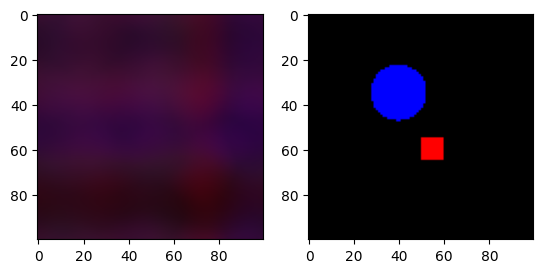

In [22]:
compare()